#Class-Conditional Bernoulli Mixture Model for EMNIST

## Setup


In [1]:
!git clone --depth 1 https://github.com/probml/pyprobml /pyprobml &> /dev/null
%cd -q /pyprobml/scripts

In [2]:
!pip install -q superimport
!pip install -q distrax

In [3]:
from conditional_bernoulli_mix_lib import ClassConditionalBMM
from conditional_bernoulli_mix_utils import (
    fake_test_data,
    encode,
    decode,
    get_decoded_samples,
    get_emnist_images_per_class,
)
from noisy_spelling_hmm import Word

from jax import vmap
import jax.numpy as jnp
import jax
from jax.random import PRNGKey, split

import numpy as np
from matplotlib import pyplot as plt

In [4]:
select_n = 25
dataset, targets = get_emnist_images_per_class(select_n)
dataset, targets = jnp.array(dataset), jnp.array(targets)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Initialization of Class Conditional BMMs

In [5]:
n_mix = 30
n_char = 52

mixing_coeffs = jnp.array(np.full((n_char, n_mix), 1.0 / n_mix))

p_min, p_max = 0.4, 0.6
n_pixels = 28 * 28
probs = jnp.array(np.random.uniform(p_min, p_max, (n_char, n_mix, n_pixels)))

class_priors = jnp.array(np.full((n_char,), 1.0 / n_char))

cbm_gd = ClassConditionalBMM(mixing_coeffs=mixing_coeffs, probs=probs, class_priors=class_priors, n_char=n_char)
cbm_em = ClassConditionalBMM(mixing_coeffs=mixing_coeffs, probs=probs, class_priors=class_priors, n_char=n_char)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


## Full Batch Gradient Descentt

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


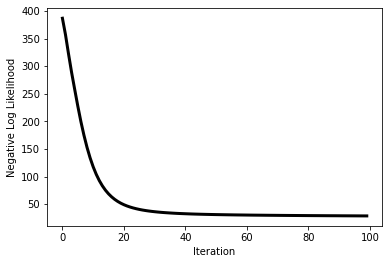

In [6]:
num_epochs, batch_size = 100, len(dataset)
losses = cbm_gd.fit_sgd(dataset.reshape((-1, n_pixels)), targets, batch_size, num_epochs=num_epochs)

plt.plot(losses, color="k", linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("Negative Log Likelihood")
plt.show()

## EM Algorithm

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


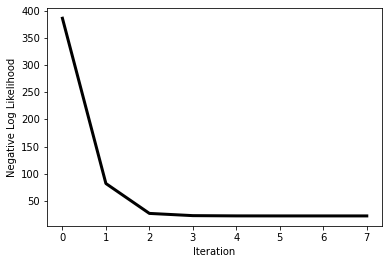

In [7]:
losses = cbm_em.fit_em(dataset, targets, 8)

plt.plot(losses, color="k", linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("Negative Log Likelihood")
plt.show()

## Plot of the Probabilities of Components Distribution

In [8]:
def plot_components_dist(cbm, n_mix):
    fig = plt.figure(figsize=(45, 20))
    for k in range(n_mix):
        for cls in range(cbm.num_of_classes):
            plt.subplot(n_mix, cbm.num_of_classes, cbm.num_of_classes * k + cls + 1)
            plt.imshow(
                1 - cbm.model.components_distribution.distribution.probs[cls][k, :].reshape((28, 28)), cmap="gray"
            )
            plt.axis("off")
    plt.tight_layout()
    plt.show()

### GD

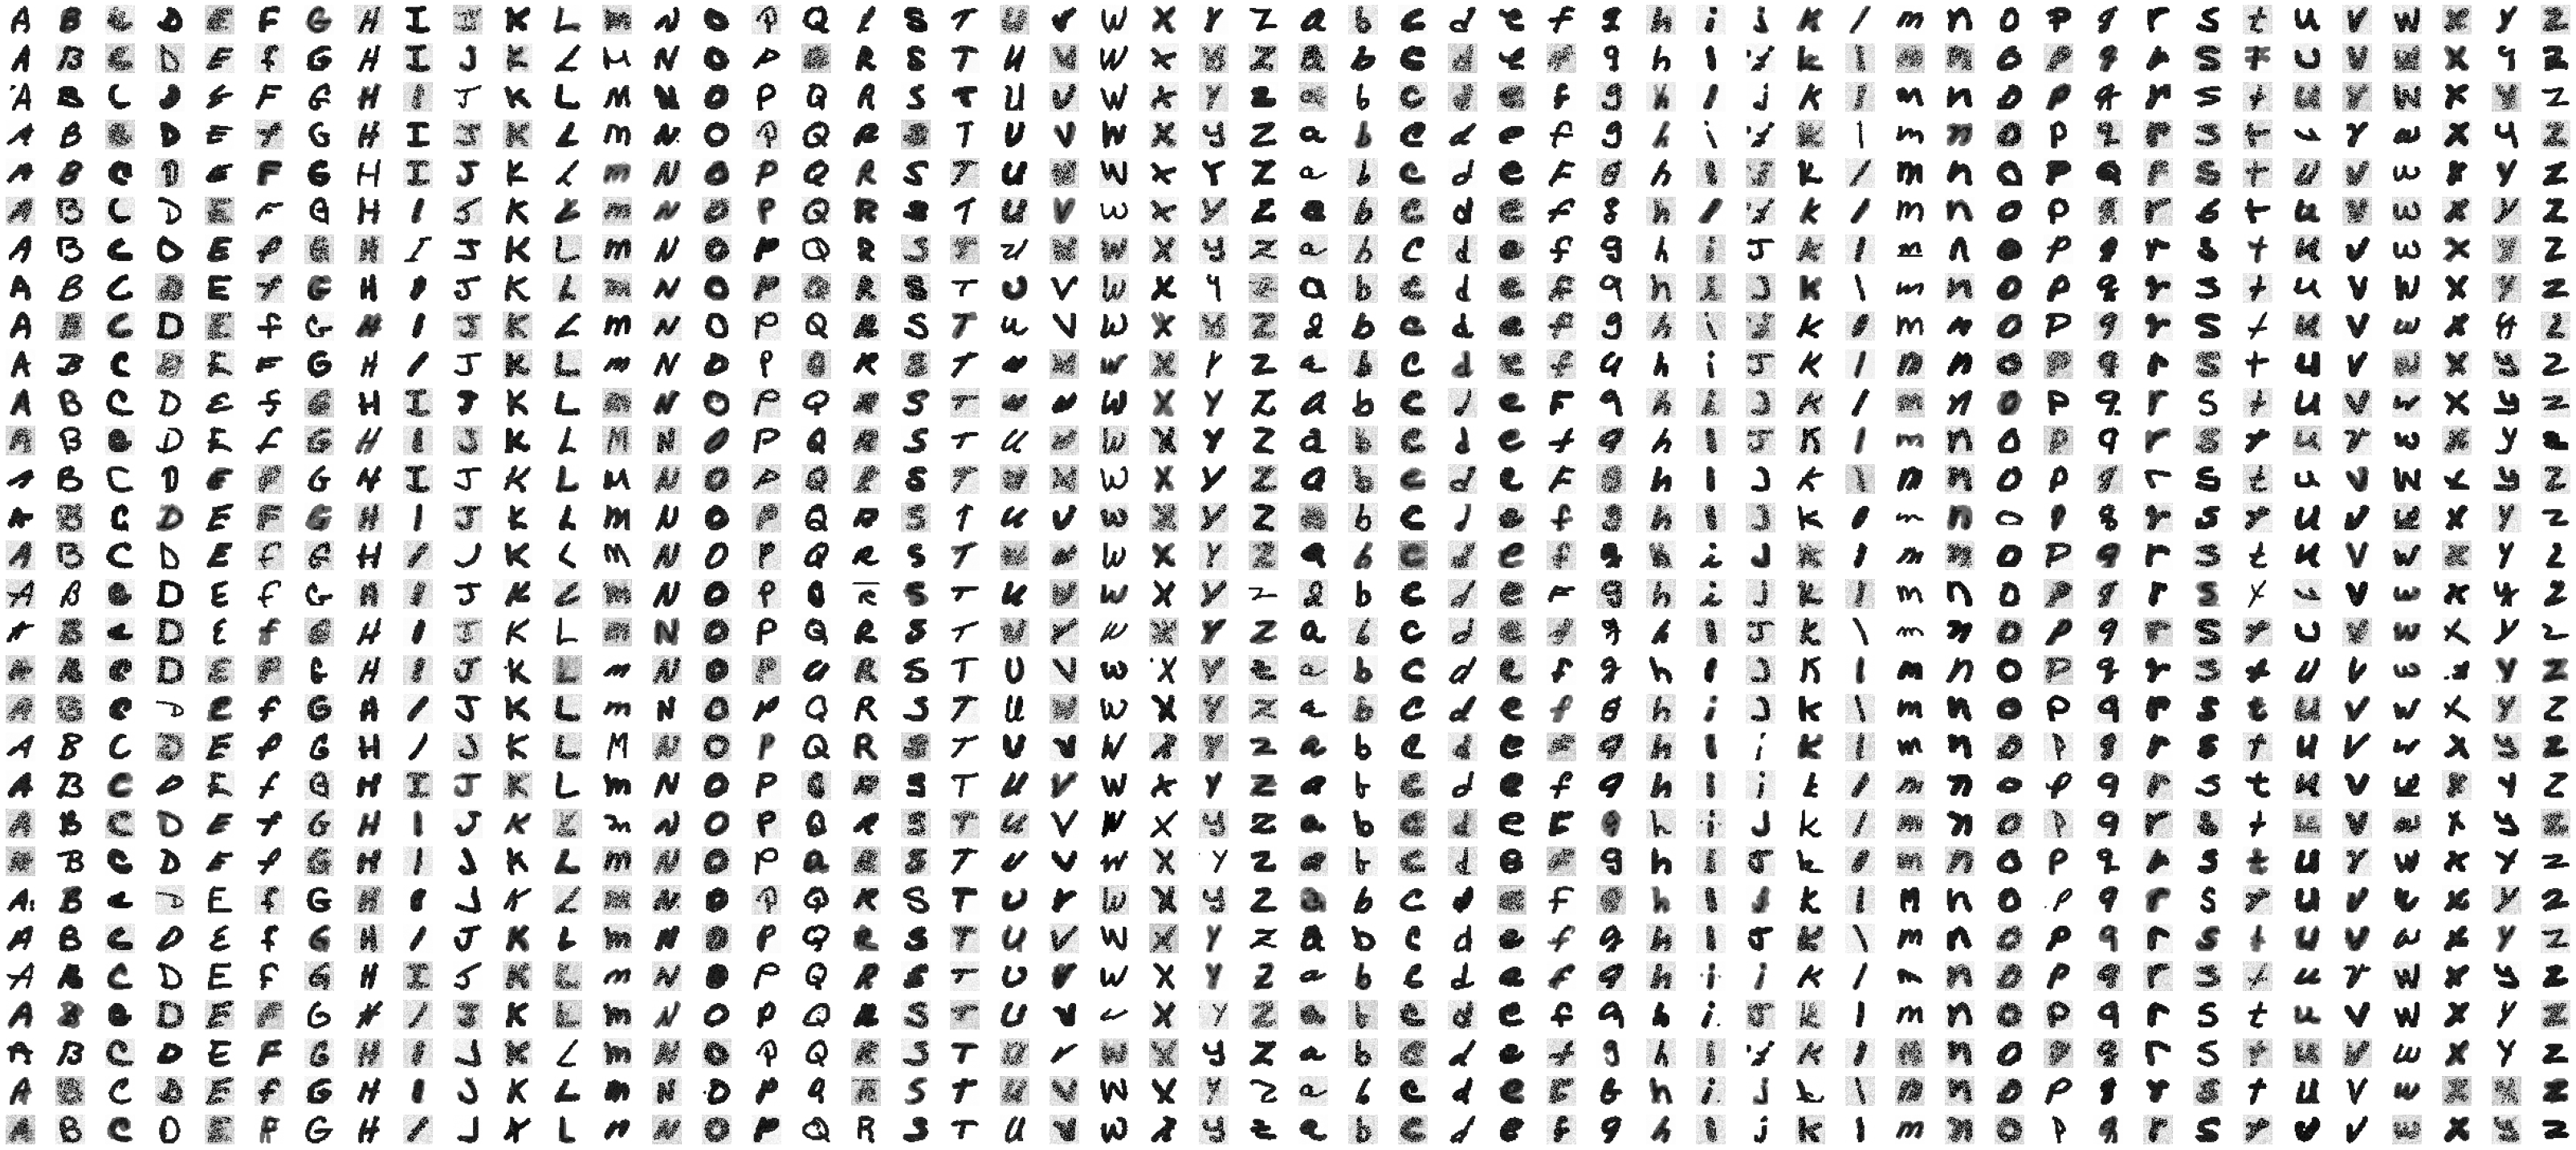

In [9]:
plot_components_dist(cbm_gd, n_mix)

### EM

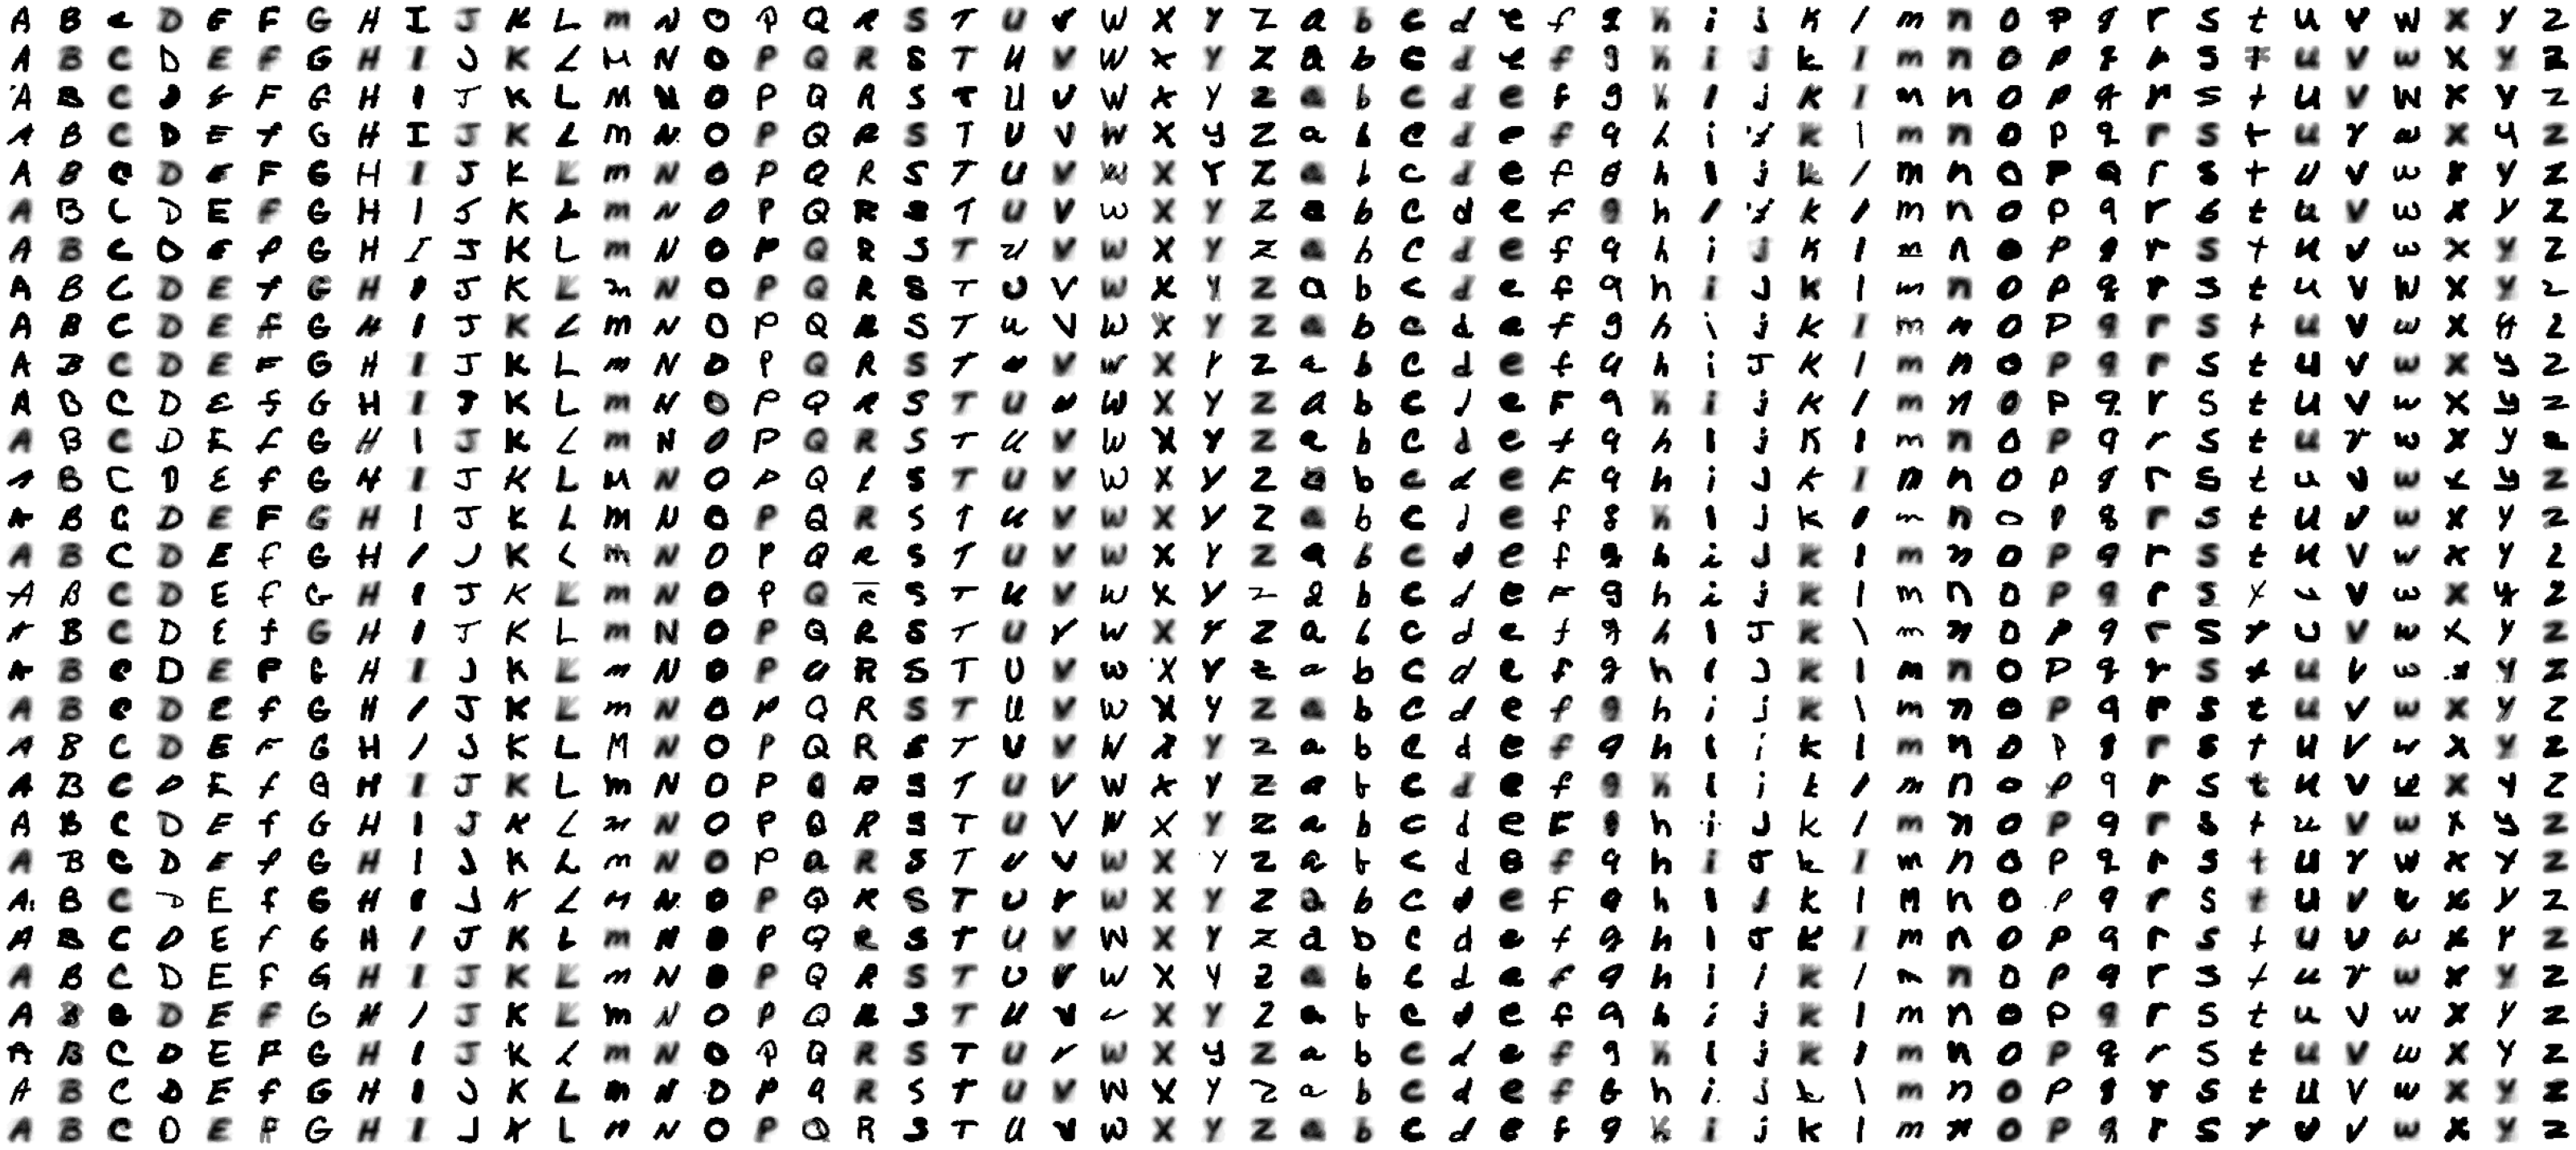

In [10]:
plot_components_dist(cbm_em, n_mix)

## Sampling

In [11]:
p1, p2, p3 = 0.4, 0.1, 2e-3
n_misspelled = 1  # number of misspelled words created for each class

vocab = ["book", "bird", "bond", "bone", "bank", "byte", "pond", "mind", "song", "band"]

rng_key = PRNGKey(0)
keys = [dev_array for dev_array in split(rng_key, len(vocab))]

In [12]:
hmms = {
    word: Word(
        word,
        p1,
        p2,
        p3,
        n_char,
        "all",
        mixing_coeffs=cbm_em.model.mixture_distribution.probs,
        initial_probs=cbm_em.model.components_distribution.distribution.probs,
        n_mix=n_mix,
    )
    for word in vocab
}

samples = jax.tree_map(lambda word, key: hmms[word].n_sample(n_misspelled, key), vocab, keys)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [13]:
decoded_words = vmap(decode, in_axes=(0, None, None))(
    jnp.array(samples)[:, :, :, -1].reshape((n_misspelled * len(vocab), -1)), n_char + 1, "all"
)
get_decoded_samples(decoded_words)

array(['b-Ok', 'BIRd', 'Bond', 'bONE', 'BANK', 'ByTe', 'OALD', 'mInD',
       'dOnG', 'bA-D'], dtype='<U4')

### Figure

In [14]:
def plot_samples(samples):
    samples = np.array(samples)[:, :, :, :-1].reshape((-1, 28, 28))
    fig, axes = plt.subplots(ncols=4, nrows=10, figsize=(4, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.001)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap="gray")
        ax.set_axis_off()

    fig.tight_layout()
    plt.show()

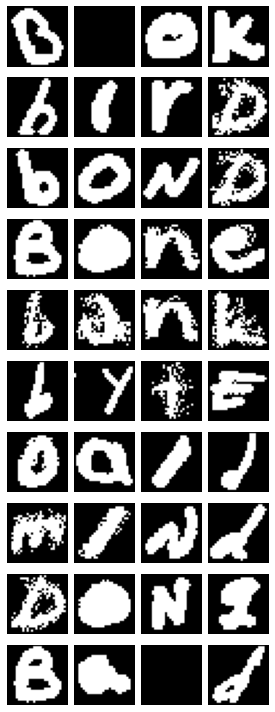

In [15]:
plot_samples(samples)

## Calculation of Log Likelihoods for Test Data

In [16]:
# noisy words
test_words = ["bo--", "-On-", "b-N-", "B---", "-OnD", "b--D", "---D", "--Nd", "B-nD", "-O--", "b--d", "--n-"]
test_images = fake_test_data(test_words, dataset, targets, n_char + 1, "all")

In [17]:
def plot_log_likelihood(hmms, test_words, test_images, vocab):
    fig, axes = plt.subplots(4, 3, figsize=(20, 10))

    for i, (ax, img, word) in enumerate(zip(axes.flat, test_images, test_words)):

        flattened_img = img.reshape((len(img), -1))
        loglikelihoods = jax.tree_map(lambda w: jnp.sum(hmms[w].loglikelihood(word, flattened_img)), vocab)
        loglikelihoods = jnp.array(loglikelihoods)

        ax.bar(vocab, jnp.exp(jax.nn.log_softmax(loglikelihoods)), color="black")
        ax.set_title(f"{word}")

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


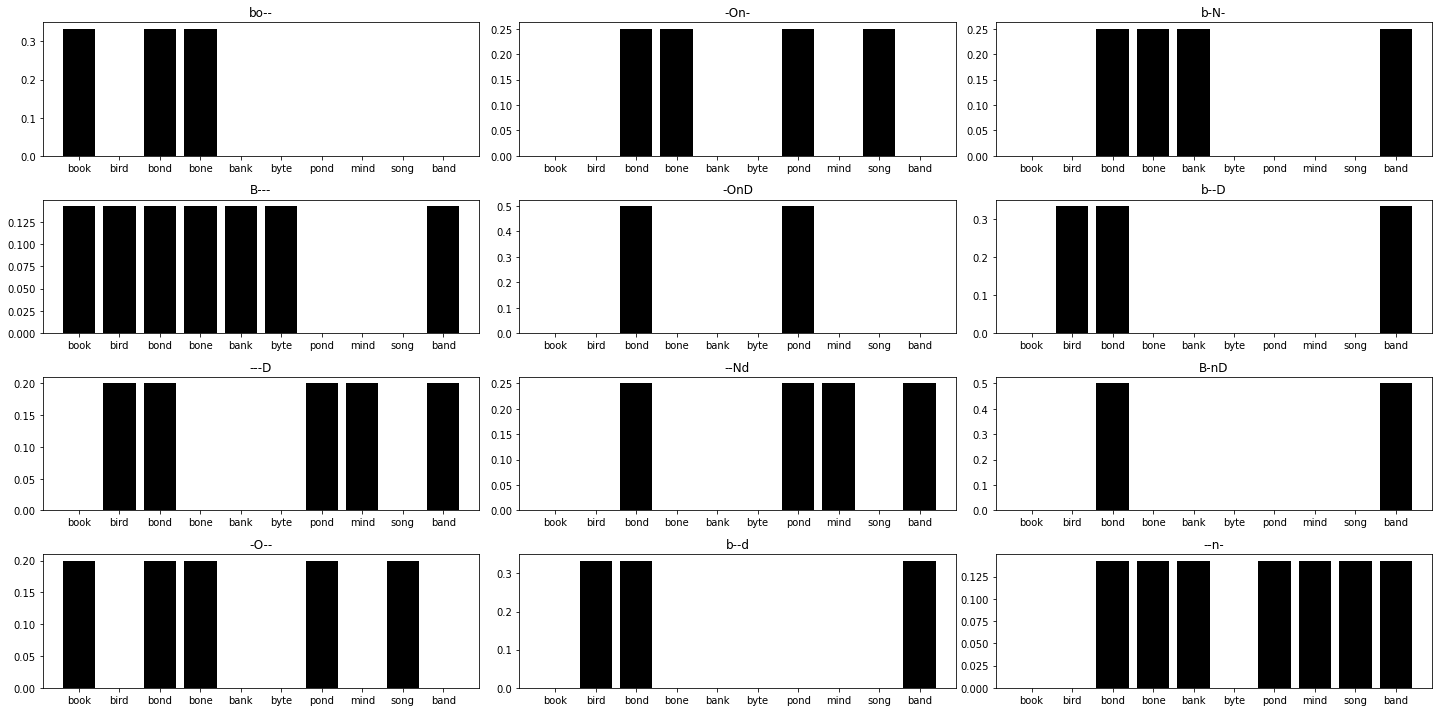

In [18]:
plot_log_likelihood(hmms, test_words, test_images, vocab)